# Combine features

At this stage we are going to combine the behavioural, eeg and mri data.

We are then gonna train a linear model with the purpose to both reconstruct the original data based on a latent space but also based on the predictions for the multi-label problem

For these experiments, we have omitted multiple same diagnoses for the same patient. That means that multiple diagnoses of Neurological diseases for instance will be eliminated.

In [0]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
rcParams['font.size'] = 12

plt.style.use('ggplot')

In [123]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [124]:
# !rm *.py
!ls

autoencode_predict.py	 autoencode_sequence_predict.py  sample_data
autoencoder_seq_predict  disorder_generator.py		 utils.py
autoencode_seq.py	 __pycache__			 visualizations.py


In [5]:
# upload python files
from google.colab import files

uploaded = files.upload()

Saving utils.py to utils.py
Saving visualizations.py to visualizations.py
Saving autoencode_sequence_predict.py to autoencode_sequence_predict.py
Saving autoencode_seq.py to autoencode_seq.py
Saving autoencode_predict.py to autoencode_predict.py
Saving disorder_generator.py to disorder_generator.py


In [0]:
import umap
import tensorflow as tf
from autoencode_predict import AutoencodePredict
from autoencode_seq import AutoencodeSeq
from autoencode_sequence_predict import AutoencodeSeqPredict
from utils import multi_label_accuracy, f1_per_class, precision_recall, get_predictions_from_sequences, count_correct
from visualizations import plot_categories
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler

from matplotlib import animation
from matplotlib import rc
from IPython.core.display import HTML
rc('animation', html='jshtml')

## Combine features

### Load behavioural data and preprocess dataset

In [126]:
base_dir = '/gdrive/My Drive/Colab Notebooks/DSLab/data'

behaviour_data = pd.read_csv(os.path.join(base_dir, 'HBNFinalSummaries.csv'), low_memory=False)

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[behaviour_data['NoDX'].isin(['Yes', 'No'])]
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their evaluation was incomplete.')

keep_most_common_diseases = 5
healthy_diagnosis = 'No Diagnosis Given'

# these disorders should also include the no diagnosis given option
keep_most_common_diseases += 1

category_columns = ['DX_' + str(i).zfill(2) + '_Cat' for i in range(1, 11)]

# count for each disorder number of occurences
disorder_counts = {}
for val in behaviour_data[category_columns].values.reshape(-1):
    if not pd.isnull(val):
        if val in disorder_counts:
            disorder_counts[val] += 1
        else:
            disorder_counts[val] = 1

# sort in descending order
disorder_counts = sorted(disorder_counts.items(), key=lambda kv: -kv[1])

most_common_disorders = [x[0]
                         for x in disorder_counts[:keep_most_common_diseases]]

# find users that have no diagnosis within these top diseases
# filtering should cahnge anything as this should also happen at a later stage
mask = None
for col in category_columns:
    mask_col = behaviour_data[col].isin(most_common_disorders)
    if mask is None:
        mask = mask_col
    else:
        mask = mask | mask_col

initial_size = behaviour_data.shape[0]
behaviour_data = behaviour_data[mask]
behaviour_data = behaviour_data.reset_index(drop=True)
new_size = behaviour_data.shape[0]
print('Removing', initial_size - new_size,
      'patients as their diagnoses were very uncommon.')

Removing 282 patients as their evaluation was incomplete.
Removing 37 patients as their diagnoses were very uncommon.


In [0]:
no_diagnosis_given = 'No Diagnosis Given'

if no_diagnosis_given in most_common_disorders:
    no_diag_index = most_common_disorders.index(no_diagnosis_given)
    most_common_disorders = most_common_disorders[:no_diag_index] + \
        most_common_disorders[no_diag_index + 1:]

In [0]:
diagnoses_to_ids = {disorder: i for i, disorder in enumerate(most_common_disorders)}

In [0]:
order_of_disorders = []
for k in range(behaviour_data.shape[0]):
    i = 0
    disorder = behaviour_data.iloc[k][category_columns[i]]
    disorders_patient = []
    while disorder != no_diagnosis_given and not pd.isnull(disorder):
        if disorder in diagnoses_to_ids:
            if diagnoses_to_ids[disorder] not in disorders_patient:
                disorders_patient.append(diagnoses_to_ids[disorder])
        i += 1
        if i == len(category_columns):
            break
        disorder = behaviour_data.iloc[k][category_columns[i]]

    order_of_disorders.append(disorders_patient)

In [0]:
max_len_order = np.max([len(x) for x in order_of_disorders])

# pad with a new token denoting the pad token
pad_token = len(most_common_disorders)
bod_token = len(most_common_disorders) + 1
eod_token = len(most_common_disorders) + 2

order_of_disorders = [[bod_token] + x + [eod_token] + [pad_token] * (max_len_order - len(x)) for x in order_of_disorders]

order_of_disorders = np.array(order_of_disorders)

Many diseases are also present many times. What should we do with them? I have only considered the first presence of a disorder for a patient! 

In [0]:
classes = np.zeros((len(most_common_disorders),
                    behaviour_data.shape[0]), dtype=np.int32)


df_disorders = behaviour_data[category_columns]

for i, disorder in enumerate(most_common_disorders):
    mask = df_disorders.select_dtypes(include=[object]). \
        applymap(lambda x: disorder in x if pd.notnull(x) else False)

    disorder_df = df_disorders[mask.any(axis=1)]

    np.add.at(classes[i], disorder_df.index.values, 1)

In [0]:
behaviour_data_columns = behaviour_data.columns.values.astype(np.str)

columns_to_drop = behaviour_data_columns[
    np.flatnonzero(np.core.defchararray.find(behaviour_data_columns, 'DX') != -1)]

behaviour_data = behaviour_data.drop(columns=columns_to_drop)

In [0]:
for disorder, classification in zip(most_common_disorders, classes):
    behaviour_data[disorder] = classification

behaviour_data['order_diagnoses'] = list(order_of_disorders)

In [134]:
behaviour_data.shape

(1777, 312)

In [0]:
combined_df = behaviour_data.set_index('EID')

### Load mri and add to dataset

In [0]:
fa_per_tract = pd.read_csv(os.path.join(base_dir, 'FAPerTract.csv'), low_memory=False)

# Remove "/" from the end some IDs 
fa_per_tract['ID'] = fa_per_tract['ID'].apply(lambda x: x[:-1] if "/" in x else x)
fa_per_tract = fa_per_tract.drop(columns=['ScanSite'])

# join with behavioural data
combined_df = combined_df.join(fa_per_tract.set_index('ID'), how='inner')

In [0]:
# base_dir = 'DataScience2019_MRI/MRI/structuralMRI'

# column ScanSite already exists in the behavioural data
cort_thick_l = pd.read_csv(os.path.join(base_dir,
    'CorticalThicknessLHROI.csv'), low_memory=False).drop(columns=['ScanSite'])
cort_thick_r = pd.read_csv(os.path.join(base_dir,
    'CorticalThicknessRHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
cort_vol_l = pd.read_csv(os.path.join(base_dir,
    'CorticalVolumeLHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
cort_vol_r = pd.read_csv(os.path.join(base_dir,
    'CorticalVolumeRHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_l = pd.read_csv(os.path.join(base_dir,
    'SubCorticalVolumeLHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
sub_cort_vol_r = pd.read_csv(os.path.join(base_dir,
    'SubCorticalVolumeRHROI.csv'), low_memory=False).drop(columns=['eTIV', 'ScanSite'])
glob_thick = pd.read_csv(os.path.join(base_dir,
    'GlobalCorticalThickness.csv'), low_memory=False).drop(columns=['ScanSite'])

# Join tables 
struct_mri = pd.merge(cort_thick_l, cort_thick_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_l, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, sub_cort_vol_r, on='ID', how='inner')
struct_mri = pd.merge(struct_mri, glob_thick, on='ID', how='inner')

combined_df = combined_df.join(struct_mri.set_index('ID'), how='inner')

In [137]:
combined_df.shape

(1053, 685)

### Load EEG  and add to dataset

In [0]:
eeg_mic = pd.read_csv(os.path.join(base_dir, "RestingEEG_Microstates.csv"))
eeg_psd = pd.read_csv(os.path.join(base_dir, "RestingEEG_PSD_Average.csv"))
eeg_spectro = pd.read_csv(os.path.join(base_dir, "RestingEEG_Spectro_Average.csv"))

In [0]:
combined_df = combined_df.join(eeg_mic.set_index('id'), how='inner')
combined_df = combined_df.join(eeg_psd.set_index('id'), how='inner')
combined_df = combined_df.join(eeg_spectro.set_index('id'), how='inner')

combined_df.shape

(597, 1110)

### Some final preprocessing

In [0]:
# fdx and mdx may contain 'No Diagnosis'
# drop them for now but they may be important
# they correspond to father's and mother's primary diagnosis
columns_to_drop = ['Anonymized.ID', 'mdx', 'fdx', 'fcodxm_1', 'fcodxm_2', 'fcodxm_3', 'mcodxm_1',
                   'mcodxm_2', 'mcodxm_3', 'mcodxmdt', 'TOWRE_Total_Desc', 'Picture_Vocab_Raw',
                   'sib1dx', 'sib1codxm_1', 'sib1codxm_2', 'sib1codxm_3',
                   'sib2dx', 'sib2codxm_1', 'sib2codxm_2', 'sib2codxm_3',
                   'sib3dx', 'sib3codxm_1', 'sib3codxm_2', 'sib3codxm_3',
                   'sib4dx', 'sib4codxm_1', 'sib4codxm_2', 'sib4codxm_3',
                   'sib5dx', 'sib5codxm_1', 'sib5codxm_2', 'sib5codxm_3']

combined_df = combined_df.drop(columns=columns_to_drop)

In [0]:
# assert combined_df.shape == (1053, 653) # if you only include the behavioural and the structural

classes = combined_df[most_common_disorders].values
orders = np.stack(combined_df['order_diagnoses'].values)

combined_df = combined_df.drop(columns=most_common_disorders + ['order_diagnoses'])

In [140]:
combined_df.shape

(1053, 647)

## Train

For this time we have only considered the behavioural data and the structural mri as these datasets have the most ids in common.

In [141]:
def mean_imputer(x, y):
    return np.where(np.isnan(x), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), x),\
            np.where(np.isnan(y), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), y)  

# we are goint to remove some behavioral data based on their null values
drop_missing_threshold = 0.5

train_index, test_index = train_test_split(np.array(list(range(combined_df.shape[0]))), test_size=0.2, random_state=17)

train, test = combined_df.iloc[train_index], combined_df.iloc[test_index]
train_classes, test_classes = classes[train_index], classes[test_index]
train_orders, test_orders = orders[train_index], orders[test_index]

columns_mask = pd.isnull(train).sum() / train.shape[0] >= drop_missing_threshold

print('Droping this many columns:', np.sum(columns_mask))

dropped_columns = train.columns[columns_mask]

train = train.drop(columns=dropped_columns)
test = test.drop(columns=dropped_columns)

train_mask = pd.isnull(train).values.astype(np.float32)
test_mask = pd.isnull(test).values.astype(np.float32)

# deal with numpy because of some weird SettingWithCopyWarning I cannot figure out
# impute based on the mean values
train, test = mean_imputer(train.values, test.values)

scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

Droping this many columns: 130


## Autoencoder + classification

In [0]:
alpha=0.2          # parameter showing the significance of the prediction loss
activation=tf.nn.relu
layers=[50, 25]
prediction_layers=[125, 50]
dropout=0.1
regularization=1e-5
masking=0.1

model = AutoencodePredict(train.shape[1], len(most_common_disorders), alpha=alpha, activation=activation, layers=layers,
                          prediction_layers=prediction_layers, dropout=dropout, regularization=regularization, 
                          masking=masking)

In [0]:
learning_rate = 3e-3
# pos_weights = [1, 1, 1, 1, 1]
# set larger weight for instances of disorders that are very infrequent

def smoothing_fun(a, beta=1):
    return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
class_weights = [1, 1, 1, 1, 1]

decay_steps = train.shape[0] // 64 * 20
model.fit(train, train_mask, train_classes, test_data=test, test_data_mask=test_mask, test_data_labels=test_classes,
          n_epochs=1000, print_every_epochs=200, pos_weights=pos_weights, class_weights=class_weights,
          decay_steps=decay_steps)

Using only behavioural:

At epoch 2000 rec_loss:   0.0943 reg_loss:   0.1133 pred_loss:  11.0274 train_acc: 0.8756 test_acc 0.8522<br>
train f1_scores: 0.736 0.757 0.784 0.826 0.673 test f1_scores: 0.719 0.719 0.746 0.716 0.523<br>

Total recall: 0.7884615384615384<br>
Total precision: 0.6923076923076923<br>
<br>

Behavioural + structural mri:

At epoch 2000 rec_loss:   0.0151 reg_loss:   0.0533 pred_loss:   7.0952 train_acc: 0.8646 test_acc 0.8313
train f1_scores: 0.713 0.725 0.795 0.816 0.739 test f1_scores: 0.694 0.708 0.705 0.731 0.545 

Total recall: 0.7758007117437722<br>
Total precision: 0.6546546546546547<br>
<br>

In [0]:
preds = model.predict(test)

INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-800


In [0]:
print(multi_label_accuracy(test_classes, preds))
print(precision_recall(test_classes, preds))
print(f1_per_class(test_classes, preds))

print(np.sum(test_classes, axis=0))
print(np.sum(preds, axis=0))

0.842654028436019
(0.6837060702875399, 0.7615658362989324)
[0.7480296154764747, 0.7090563779691443, 0.7796194541573952, 0.7163978494623656, 0.5204545454545454]


### Lets see how our method holds againt a simple classical classifier

In [0]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def classify(data, labels, test_data, classifier):
    final_predictions = np.zeros((test_data.shape[0], labels.shape[1]), dtype=np.int16)
    for i in range(labels.shape[1]):
        classifier.fit(data, labels[:, i])
        final_predictions[:, i] = classifier.predict(test_data)

    return final_predictions

# clf = SVC(class_weight='balanced')
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)

predictions_classical = classify(train, train_classes, test, clf)

In [0]:
print(multi_label_accuracy(test_classes, predictions_classical))
print(precision_recall(test_classes, predictions_classical))
print(f1_per_class(test_classes, predictions_classical))

0.8369668246445497
(0.7011070110701108, 0.6761565836298933)
[0.7352996129721073, 0.6918120113411805, 0.7195081422399469, 0.7237255586592178, 0.48536585365853663]


SVC(class_weight='balanced')<br>
0.7146919431279621<br>
(0.6443148688046647, 0.7864768683274022)<br>
[0.691970802919708, 0.7308673469387755, 0.6461490683229814, 0.6764567114885587, 0.4330666348220683]<br>
<br>
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=4)<br>
0.8407582938388626<br>
(0.6443148688046647, 0.7864768683274022)<br>
[0.7259147001515479, 0.7204493087557604, 0.6844466600199401, 0.7401477832512315, 0.48536585365853663]

### Clustering patients based on the latent space (I have dones these plots for the train dataset but the final result should probably be on the test dataset)

In [0]:
latent_space = model.get_latent_space(train)

INFO:tensorflow:Restoring parameters from ./autoencoder_predict/model-800


#### Existence of a particular disorder

In [0]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_space)

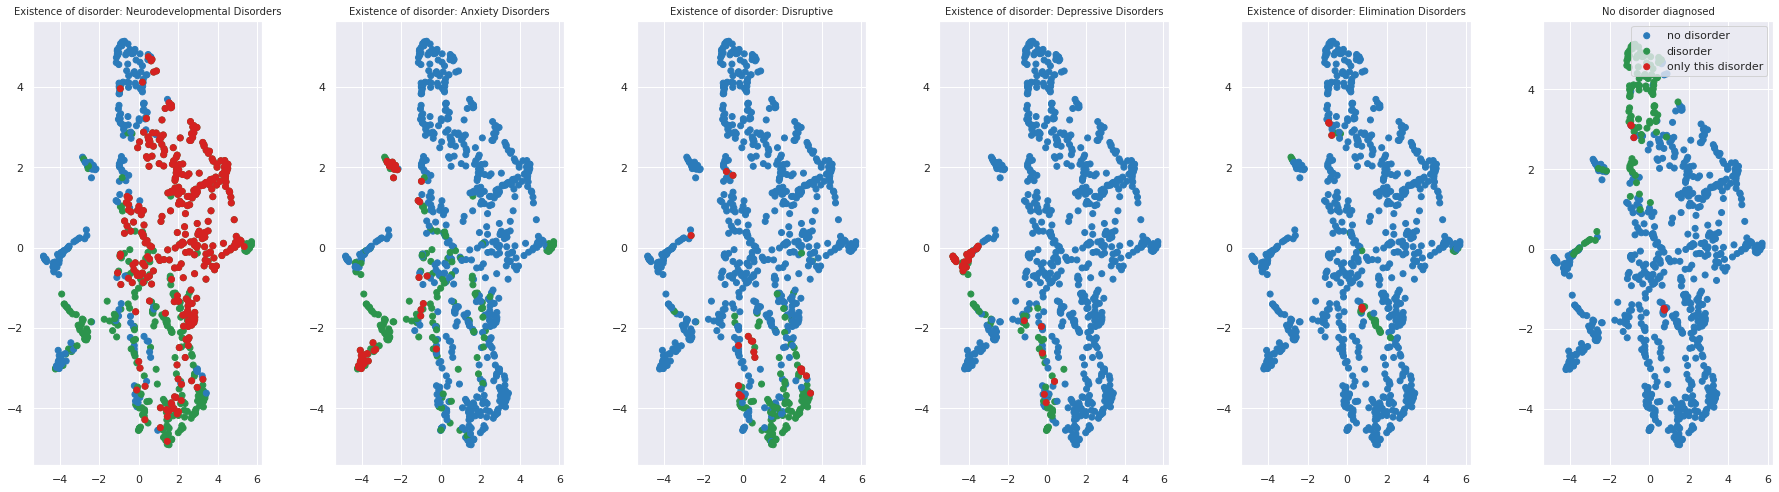

In [0]:
plot_categories(embedding, train_classes, most_common_disorders)

In [0]:
fig = plt.figure(figsize=(15, 8))
ax = plt.axes(xlim=(np.min(embedding[:, 0]) * 1.1, np.max(embedding[:, 0]) * 1.1), 
              ylim=(np.min(embedding[:, 1]) * 1.1, np.max(embedding[:, 1]) * 1.1))
ax.set_xticks([])
ax.set_yticks([])

scatter = ax.scatter(embedding[:, 0], embedding[:, 1])
title = ax.text(0.5,1.05,"Original data", size=plt.rcParams["axes.titlesize"], 
                ha="center", transform=ax.transAxes, )


blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]

def update(frame_number):
    
    disorder_index = frame_number

    if disorder_index == len(most_common_disorders):
        no_disease = np.zeros(embedding.shape[0])
        no_disease[np.where(np.sum(train_classes, axis=1) == 0)[0]] = 1
        scatter.set_sizes([60 if x == 1 else 20 for x in no_disease])
        scatter.set_color([green if x == 1 else blue for x in no_disease])
        title.set_text('No disorder')
    else:
        scatter.set_sizes([60 if x == 1 else 20 for x in train_classes[:, disorder_index]])
        scatter.set_color([green if x == 1 else blue for x in train_classes[:, disorder_index]])
        title.set_text('Disorder: {}'.format(most_common_disorders[disorder_index]))
    return scatter, 

anim = animation.FuncAnimation(fig, update, interval=2000, frames=list(range(len(most_common_disorders) + 1)))
plt.close(fig)
HTML(anim.to_html5_video())

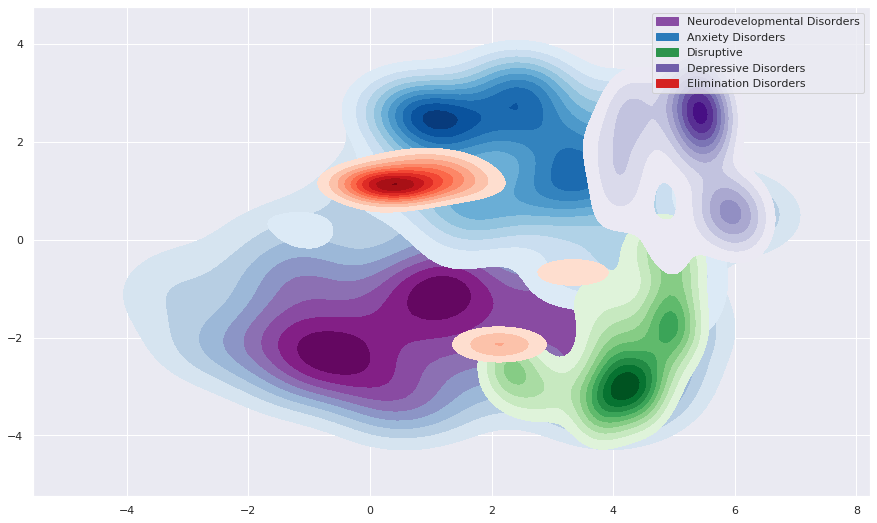

In [0]:
sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

# Set up the figure
f, ax = plt.subplots(figsize=(15, 9))

cmaps = ["BuPu", "Blues", "Greens", "Purples", "Reds"]
for i in range(len(most_common_disorders)):
    indx = np.where(train_classes[:, i] == 1)[0]
    color = sns.color_palette(cmaps[i])[-2]
    sns.kdeplot(embedding[indx, 0], embedding[indx, 1], cmap=cmaps[i], shade=True, shade_lowest=False, label=most_common_disorders[i], color=color)

ax.legend()

#### Disorder by position

Number of instances per disorder
[605 201 125  90  35]


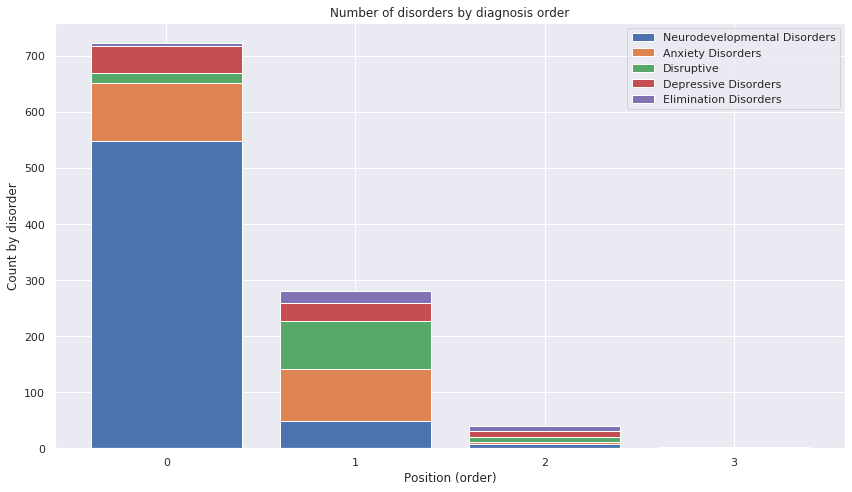

In [0]:
# all possible predictions orders
max_posiitions = max_len_order

# plot most likely disorder by position
count_disorders = np.zeros((max_posiitions, len(most_common_disorders)))
for i in range(1, max_posiitions + 1):
    for dis in range(len(most_common_disorders)):
        count_disorders[i - 1, dis] = len(np.where(train_orders[:, i] == dis)[0])

print('Number of instances per disorder')
print(np.sum(train_classes, axis=0))

positions = list(range(max_posiitions))

plt.figure(figsize=(12,7))

# stack bars
plt.bar(positions, count_disorders[:, 0], label=most_common_disorders[0])
prev = count_disorders[:, 0]

for i in range(1, len(most_common_disorders)):
    b = plt.bar(positions, count_disorders[:, i], bottom=prev, label=most_common_disorders[i])
    prev = np.cumsum(count_disorders, axis=1)[:, i]

plt.xlabel(list(range(1, max_posiitions + 1)))
plt.xticks(list(range(0, max_posiitions)))
plt.xlabel('Position (order)')
plt.ylabel('Count by disorder')
plt.legend()
plt.title('Number of disorders by diagnosis order')
plt.tight_layout()
plt.show()

#### Iteractions between disorders

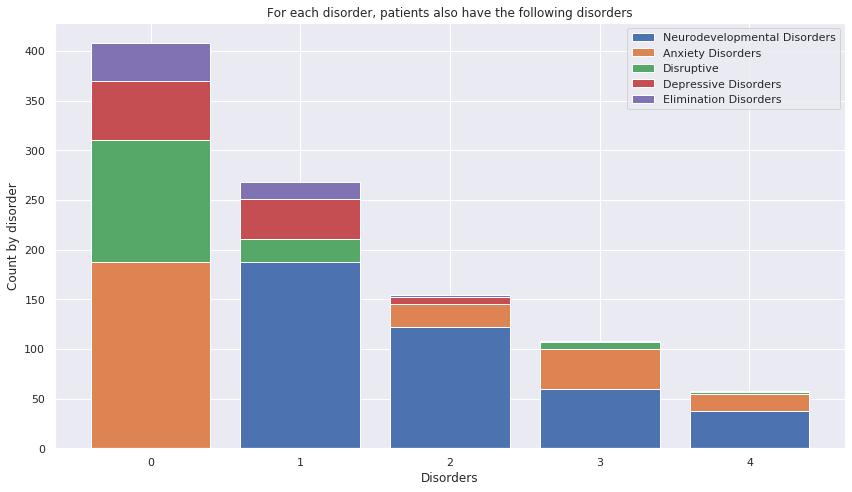

In [0]:
# those who have neural, aslo have ?

disorder_other_disorder = np.zeros((len(most_common_disorders), len(most_common_disorders)))
for index in range(len(most_common_disorders)):
    ind = np.where(classes[:, index] == 1)[0]
    disorder_other_disorder[index, :] = np.sum(classes[ind], axis=0)

disorder_other_disorder[range(len(most_common_disorders)), range(len(most_common_disorders))] = 0

plt.figure(figsize=(12,7))

positions = list(range(len(most_common_disorders)))

# stack bars
plt.bar(positions, disorder_other_disorder[:, 0], label=most_common_disorders[0])
prev = disorder_other_disorder[:, 0]

for i in range(1, len(most_common_disorders)):
    b = plt.bar(positions, disorder_other_disorder[:, i], bottom=prev, label=most_common_disorders[i])
    prev = np.cumsum(disorder_other_disorder, axis=1)[:, i]

plt.xlabel(most_common_disorders)
plt.xticks(list(range(0, len(most_common_disorders))))
plt.xlabel('Disorders')
plt.ylabel('Count by disorder')
plt.legend()
plt.title('For each disorder, patients also have the following disorders')
plt.tight_layout()
plt.show()

### Better visualization of the latent space for all combinations of labels (define better colors for these)

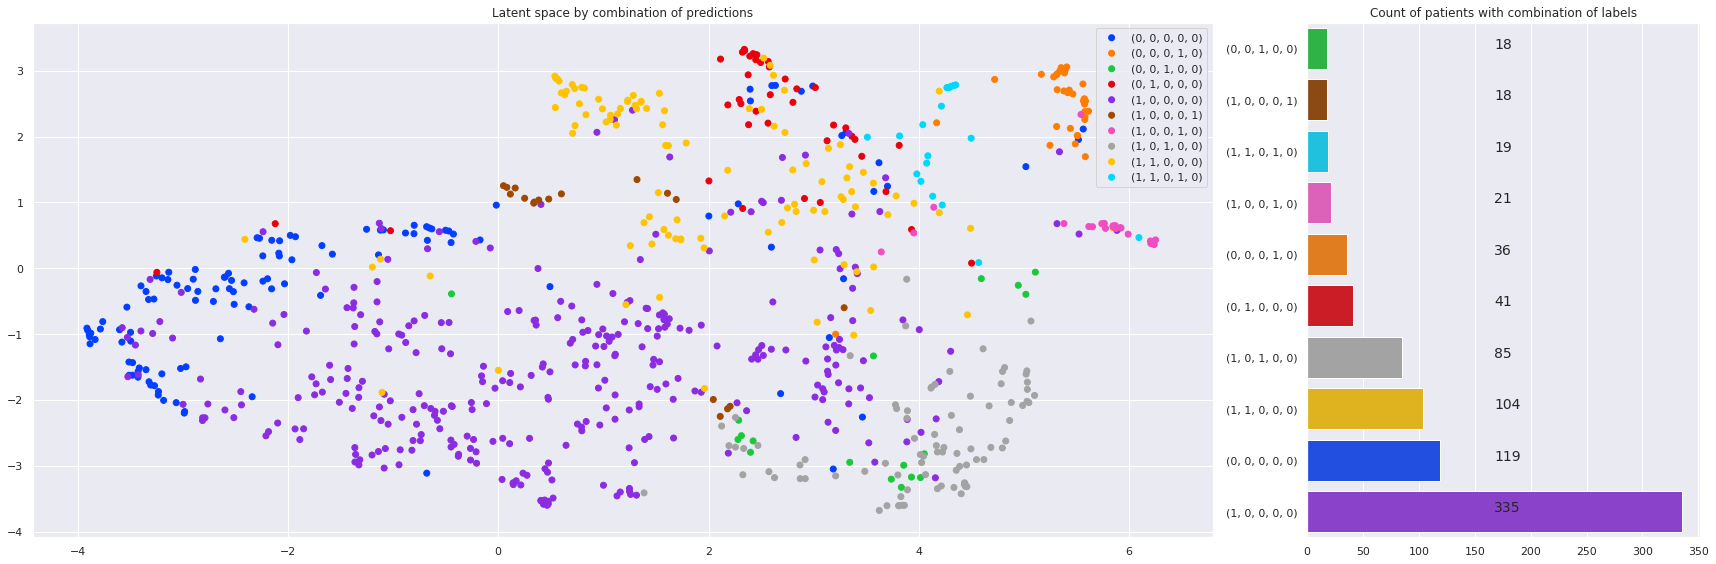

In [0]:
# TODO make this plot more informative!

# all possible combinations of classes
def combinations(classes):
    combos = list(set([tuple(x) for x in classes]))
    combos = sorted(combos, key=lambda tup: (tuple([tup[x] for x in range(len(combos[0]))])))
    indices = np.zeros((classes.shape[0], len(combos)))

    for i in range(len(combos)):
        indices[:, i] = [combos[i] == tuple(x) for x in classes]

    return [str(x) for x in combos], indices

combos, indices = combinations(train_classes)
per_category_counts = np.sum(indices, axis=0)

# keep only combination of labels with at least this many patients
thres = 10
ind = np.where(per_category_counts > thres)[0]
combos = np.array(combos)[ind]
indices = indices[:, ind]
# recompute per category counts

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), gridspec_kw={'width_ratios': [3, 1]})

for i in range(len(combos)):
    indx = np.where(indices[:, i] == 1)[0]
    ax[0].scatter(embedding[indx, 0], embedding[indx, 1], 
                c=[sns.color_palette("bright", len(combos))[i] for _ in range(len(indx))], label=combos[i])

ax[0].legend()
ax[0].set_title('Latent space by combination of predictions')

args = np.argsort(per_category_counts[ind])
sorted_values = np.sort(per_category_counts[ind])
ax[1] = sns.barplot(x=sorted_values, y=np.array(combos)[args], 
                    palette=np.array(sns.color_palette("bright", len(combos)))[args])

mean_val = np.max(sorted_values) / 2
for i in range(len(ind)):
    ax[1].text(mean_val, i, int(sorted_values[i]), fontsize=14)

ax[1].set_title('Count of patients with combination of labels')

plt.tight_layout()
plt.show()

## Only sequences and reconstruction error

In [0]:
beta=.01
activation=tf.nn.relu
layers=[100, 50] #[50, 25]
dropout=0.1
regularization=0 # 1e-4
masking=0.1

embed_size = 15
rnn_size = 64
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
# three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeq(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                             embed_size, bod_token, eod_token, pad_token, beta=beta, activation=activation,
                             layers=layers, dropout=dropout, regularization=regularization, masking=masking)

In [0]:
learning_rate = 0.001
batch_size = 64
decay_steps = train.shape[0] // batch_size * 20

model.fit(train, train_mask, train_orders, test_data=test, test_data_mask=test_mask, 
          test_data_orders=test_orders, n_epochs=1000, print_every_epochs=50, 
          learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)

In [0]:
# sequences predictions
sequences = model.predict_sequences(test)
predictions_from_sequences = get_predictions_from_sequences(sequences, len(most_common_disorders))

# precision recall 
print(multi_label_accuracy(test_classes, predictions_from_sequences))
print(precision_recall(test_classes, predictions_from_sequences))
print(f1_per_class(test_classes, predictions_from_sequences))

INFO:tensorflow:Restoring parameters from ./autoencoder_seq/model-950
0.8578199052132701
(0.7937219730941704, 0.6298932384341637)
[0.7182910547396528, 0.7033486707566462, 0.6000702000702001, 0.7208994708994709, 0.48536585365853663]


In [0]:
print(np.sum(test_classes, axis=0))
print(np.sum(predictions_from_sequences, axis=0))

[154  58  28  29  12]
[161  38   9  15   0]


Again all visualizations here are only based on the train dataset

In [0]:
seq_latent_space = model.get_latent_space(train)

INFO:tensorflow:Restoring parameters from ./autoencoder_seq/model-950


In [0]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(seq_latent_space)

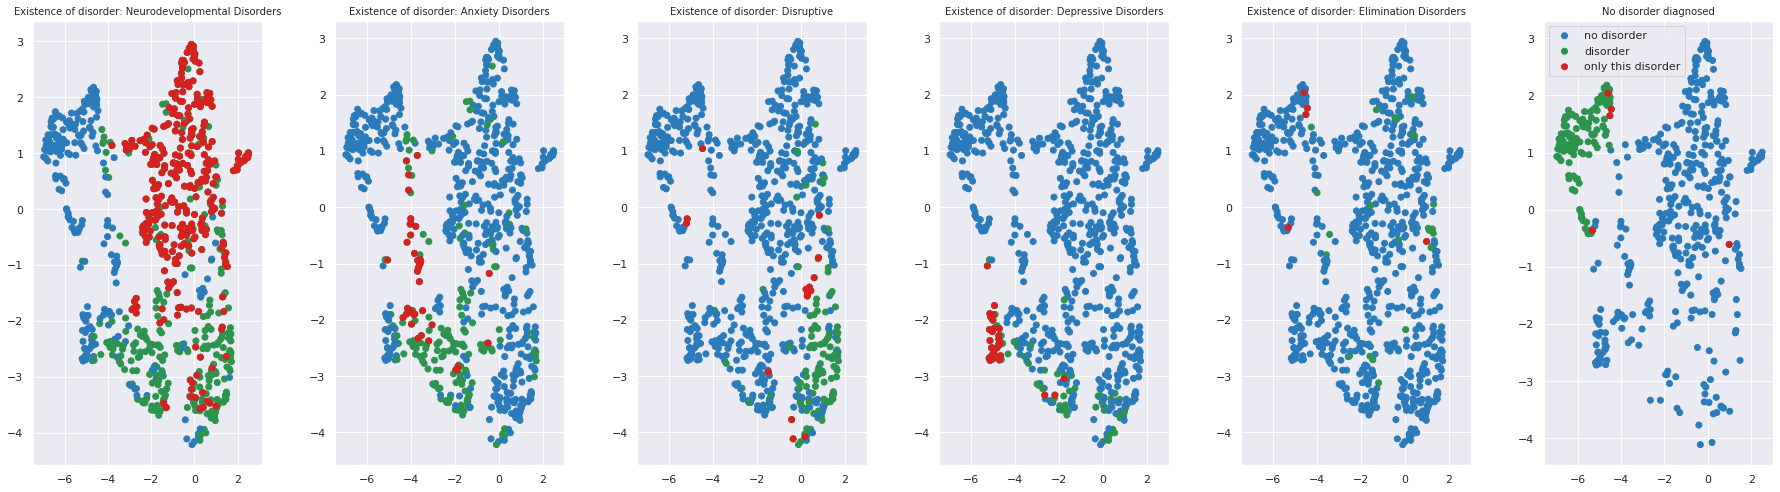

In [0]:
plot_categories(embedding, train_classes, most_common_disorders)

## Autoencoder + classification + order of diagnoses

In [0]:
alpha=.003
beta=.002
activation=tf.nn.relu
layers=[100, 55]
prediction_layers=[125, 25]
dropout=0.1
regularization=1e-5
masking=0.1


embed_size = 5
rnn_size = 32
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeqPredict(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                             embed_size, bod_token, eod_token, pad_token, alpha=alpha, beta=beta, activation=activation,
                             layers=layers, dropout=dropout, regularization=regularization, masking=masking,
                             prediction_layers=prediction_layers)

In [0]:
# set larger weight for instances of disorders that are very infrequent
def smoothing_fun(a, beta=1):
    return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
class_weights = [1, 1, 1, 1, 1]
learning_rate = 0.0015
batch_size = 64
decay_steps = train.shape[0] // batch_size * 20

model.fit(train, train_mask, train_classes, train_orders, test_data=test, test_data_mask=test_mask, 
          test_data_labels=test_classes, test_data_orders=test_orders, 
          pos_weights=pos_weights, class_weights=class_weights, n_epochs=1001, print_every_epochs=500,
          learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)

At epoch    0 rec_loss:   0.0867 reg_loss:   0.0392 pred_loss:   0.0322 seq_loss   0.0830 train_acc: 0.6447 test_acc 0.6436
	train f1_scores: 0.220 0.193 0.460 0.472 0.489 test f1_scores: 0.213 0.216 0.464 0.463 0.485  seq correct tokens train 0.5167 and test 0.4786
At epoch  500 rec_loss:   0.0148 reg_loss:   0.0055 pred_loss:   0.0164 seq_loss   0.0141 train_acc: 0.9131 test_acc 0.8445
	train f1_scores: 0.819 0.829 0.869 0.863 0.780 test f1_scores: 0.747 0.707 0.714 0.766 0.483  seq correct tokens train 0.6957 and test 0.5321
At epoch 1000 rec_loss:   0.0150 reg_loss:   0.0060 pred_loss:   0.0149 seq_loss   0.0125 train_acc: 0.9489 test_acc 0.8569
	train f1_scores: 0.897 0.922 0.895 0.902 0.860 test f1_scores: 0.740 0.737 0.735 0.734 0.484  seq correct tokens train 0.7301 and test 0.5071


In [0]:
# predictions per class
preds = model.predict(test)

print(multi_label_accuracy(test_classes, preds))
print(precision_recall(test_classes, preds))
print(f1_per_class(test_classes, preds))

print(test.shape)
print(np.sum(test_classes, axis=0))
print(np.sum(preds, axis=0))

# for comparison only autoencode + predict
# 0.8654028436018957
# (0.7263843648208469, 0.7935943060498221)
# [0.7591992844144227, 0.7711194010106622, 0.7782215682152618, 0.7464551790434992, 0.48284313725490197]

INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500
0.8597156398104265
(0.726962457337884, 0.7580071174377224)
[0.7426587860024392, 0.723570289359763, 0.7789804469273743, 0.7412924027065074, 0.48536585365853663]
(211, 517)
[154  58  28  29  12]
[169  56  36  32   0]


In [0]:
# sequences predictions
sequences = model.predict_sequences(test)

predictions_from_sequences = get_predictions_from_sequences(sequences, len(most_common_disorders))

print(multi_label_accuracy(test_classes, predictions_from_sequences))
print(precision_recall(test_classes, predictions_from_sequences))
print(f1_per_class(test_classes, predictions_from_sequences))

# 0.8625592417061612
# (0.8119266055045872, 0.6298932384341637)
# [0.7464313978368554, 0.6641057585825029, 0.6890657235484822, 0.7281094680002453, 0.48536585365853663]

INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500
0.8445497630331753
(0.8031088082901554, 0.5516014234875445)
[0.7088852097130243, 0.5827502281715851, 0.6000702000702001, 0.7246524822695035, 0.48536585365853663]


In [0]:
count_correct(test_orders[:, 1:], sequences, model.num_classes)

0.45714285714285713

alpha=.003
beta=.002
activation=tf.nn.relu
layers=[100, 55]
prediction_layers=[125, 25]
dropout=0.1
regularization=1e-5
masking=0.1


embed_size = 5
rnn_size = 32
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeqPredict(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                             embed_size, bod_token, eod_token, pad_token, alpha=alpha, beta=beta, activation=activation,
                             layers=layers, dropout=dropout, regularization=regularization, masking=masking,
                             prediction_layers=prediction_layers)

class_weights = [1, 1, 1, 1, 1]
learning_rate = 0.0015
batch_size = 64
decay_steps = train.shape[0] // batch_size * 20

num_epochs = 1001

### Visualization

INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500


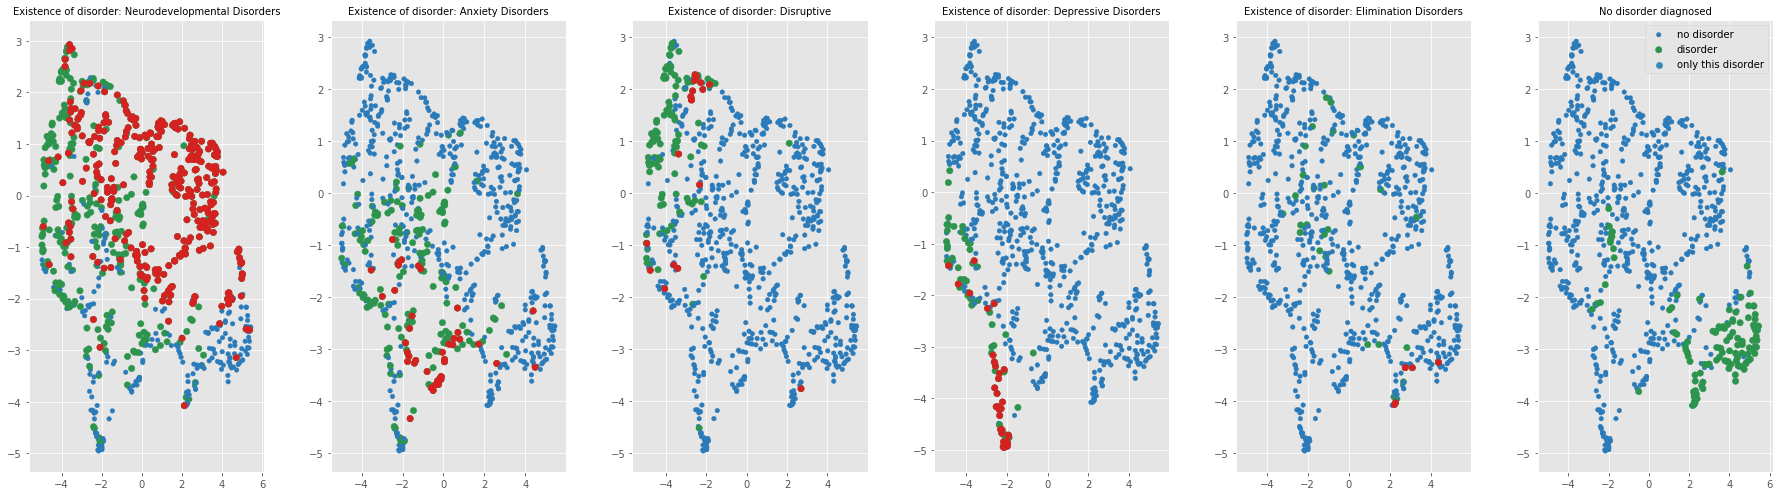

In [0]:
latent_space = model.get_latent_space(train)

reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_space)

plot_categories(embedding, train_classes, most_common_disorders)

INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500


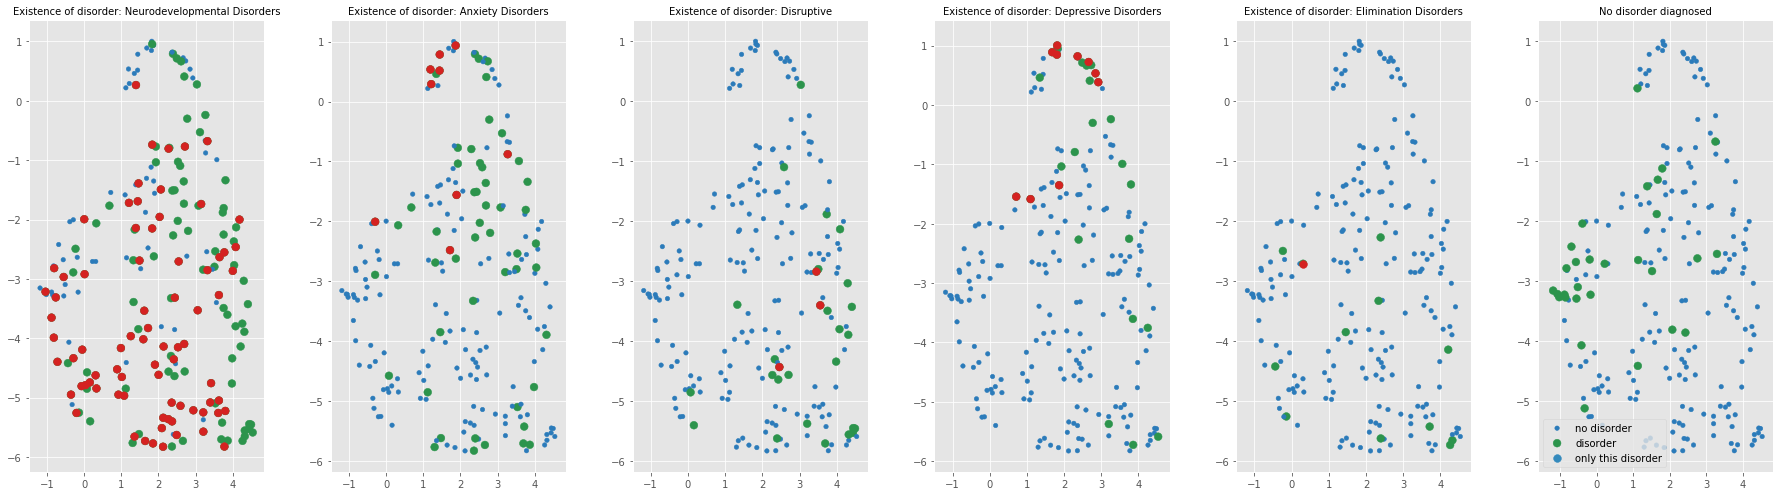

In [0]:
latent_space_test = model.get_latent_space(test)

reducer = umap.UMAP()
embedding = reducer.fit_transform(latent_space_test)

plot_categories(embedding, test_classes, most_common_disorders, large_size=60)

## Cross validation results

In [0]:
def mean_imputer(x, y):
    return np.where(np.isnan(x), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), x),\
            np.where(np.isnan(y), np.ma.array(x, mask=np.isnan(x)).mean(axis=0), y)  

    
def run_cross_validation(df, classes, orders, fit_model_and_get_predictions, n_splits=5, drop_missing_threshold=0.5):
    kf = KFold(n_splits=n_splits, random_state=17, shuffle=True)
    kf.get_n_splits(df)

    final_predictions = np.zeros(classes.shape)
    final_orders = np.zeros((orders.shape[0], orders.shape[1] - 1))

    # split
    for train_index, test_index in kf.split(df):
        train, test = df.iloc[train_index], df.iloc[test_index]
        train_classes, test_classes = classes[train_index], classes[test_index]
        train_orders, test_orders = orders[train_index], orders[test_index]

        columns_mask = pd.isnull(train).sum() / train.shape[0] >= drop_missing_threshold

        print('Droping this many columns:', np.sum(columns_mask))

        dropped_columns = train.columns[columns_mask]

        train = train.drop(columns=dropped_columns)
        test = test.drop(columns=dropped_columns)

        train_mask = pd.isnull(train).values.astype(np.float32)
        test_mask = pd.isnull(test).values.astype(np.float32)

        # deal with numpy because of some weird SettingWithCopyWarning I cannot figure out
        # impute based on the mean values
        train, test = mean_imputer(train.values, test.values)

        scaler = MinMaxScaler()
        train = scaler.fit_transform(train)
        test = scaler.transform(test)

        final_predictions[test_index], final_orders[test_index] = fit_model_and_get_predictions(\
                    train, train_mask, train_classes, train_orders, test, test_mask, test_classes, test_orders)

    return final_predictions.astype(np.int16), final_orders.astype(np.int16)

def evaluate_predictions(classes, pred_classes, orders, pred_orders):
    if pred_classes is not None:
        print('Pred classes statistics')
        print('multi_label_accuracy', multi_label_accuracy(classes, pred_classes))
        print('precision_recall', precision_recall(classes, pred_classes))
        print('f1_per_class', f1_per_class(classes, pred_classes))
    if pred_orders is not None:
        print('Pred orders statistics')
        predictions_from_sequences = get_predictions_from_sequences(pred_orders, len(most_common_disorders))
        print('multi_label_accuracy', multi_label_accuracy(classes, predictions_from_sequences))
        print('precision_recall', precision_recall(classes, predictions_from_sequences))
        print('f1_per_class', f1_per_class(classes, predictions_from_sequences))

In [0]:
def autoencode_predict_fit_predict(train, train_mask, train_classes, train_orders, 
                                   test, test_mask, test_classes, test_orders):
    alpha=0.2          # parameter showing the significance of the prediction loss
    activation=tf.nn.relu
    layers=[80, 20]
    prediction_layers=[50]
    dropout=0.1
    regularization=1e-5
    masking=0.1

    model = AutoencodePredict(train.shape[1], len(most_common_disorders), alpha=alpha, activation=activation, layers=layers,
                            prediction_layers=prediction_layers, dropout=dropout, regularization=regularization, 
                            masking=masking)    

    learning_rate = 3e-3

    def smoothing_fun(a, beta=1):
        return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

    pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
    class_weights = [1, 1, 1, 1, 1]

    decay_steps = train.shape[0] // 64 * 20
    model.fit(train, train_mask, train_classes, test_data=test, test_data_mask=test_mask, test_data_labels=test_classes,
            n_epochs=801, print_every_epochs=200, pos_weights=pos_weights, class_weights=class_weights,
            decay_steps=decay_steps)
    
    # this model cannot predict the order
    return model.predict(test), np.zeros((test_orders.shape[0], test_orders.shape[1] - 1))

pred_classes, _ = run_cross_validation(combined_df, classes, orders, autoencode_predict_fit_predict)

evaluate_predictions(classes, pred_classes, None, None)

In [0]:
def autoencode_predict_fit_predict(train, train_mask, train_classes, train_orders, 
                                   test, test_mask, test_classes, test_orders):
    beta=.01
    activation=tf.nn.relu
    layers=[100, 50]
    dropout=0.1
    regularization=0
    masking=0.1

    embed_size = 15
    rnn_size = 64
    max_generator_size = max_len_order + 2 # plus two for the bod and oed token
    # three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
    vocab_size = len(most_common_disorders) + 3

    model = AutoencodeSeq(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                                embed_size, bod_token, eod_token, pad_token, beta=beta, activation=activation,
                                layers=layers, dropout=dropout, regularization=regularization, masking=masking)

    learning_rate = 0.001
    batch_size = 64
    decay_steps = train.shape[0] // batch_size * 20

    model.fit(train, train_mask, train_orders, test_data=test, test_data_mask=test_mask, 
            test_data_orders=test_orders, n_epochs=1001, print_every_epochs=200, 
            learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)

    return np.zeros(test_classes.shape), model.predict_sequences(test)

_, pred_orders = run_cross_validation(combined_df, classes, orders, autoencode_predict_fit_predict)

evaluate_predictions(classes, None, orders, pred_orders)

In [0]:
def autoencode_predict_fit_predict(train, train_mask, train_classes, train_orders, 
                                   test, test_mask, test_classes, test_orders):
    alpha=.003
    beta=.002
    activation=tf.nn.relu
    layers=[100, 55]
    prediction_layers=[125, 25]
    dropout=0.1
    regularization=1e-5
    masking=0.1


    embed_size = 5
    rnn_size = 32
    max_generator_size = max_len_order + 2 # plus two for the bod and oed token
    vocab_size = len(most_common_disorders) + 3

    model = AutoencodeSeqPredict(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                                embed_size, bod_token, eod_token, pad_token, alpha=alpha, beta=beta, activation=activation,
                                layers=layers, dropout=dropout, regularization=regularization, masking=masking,
                                prediction_layers=prediction_layers)

    # set larger weight for instances of disorders that are very infrequent
    def smoothing_fun(a, beta=1):
        return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

    pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
    class_weights = [1, 1, 1, 1, 1]
    learning_rate = 0.0015
    batch_size = 64
    decay_steps = train.shape[0] // batch_size * 20

    model.fit(train, train_mask, train_classes, train_orders, test_data=test, test_data_mask=test_mask, 
            test_data_labels=test_classes, test_data_orders=test_orders, 
            pos_weights=pos_weights, class_weights=class_weights, n_epochs=2001, print_every_epochs=500,
            learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)

    return model.predict(test), model.predict_sequences(test)

pred_classes, pred_orders = run_cross_validation(combined_df, classes, orders, autoencode_predict_fit_predict)

evaluate_predictions(classes, pred_classes, orders, pred_orders)

alpha=0.2          # parameter showing the significance of the prediction loss
activation=tf.nn.relu
layers=[50, 25]
prediction_layers=[125, 50]
dropout=0.1
regularization=1e-5
masking=0.1

model = AutoencodePredict(train.shape[1], len(most_common_disorders), alpha=alpha, activation=activation, layers=layers,
                        prediction_layers=prediction_layers, dropout=dropout, regularization=regularization, 
                        masking=masking)

learning_rate = 3e-3
<br>
Pred classes statistics<br>
multi_label_accuracy 0.8284900284900285<br>
precision_recall (0.6420157068062827, 0.7337322363500374)<br>
f1_per_class [0.722889481071239, 0.6816317449813745, 0.7031403812824957, 0.6784007871029896, 0.49083582776882345]

=========================================================================================================

beta=.01
activation=tf.nn.relu
layers=[100, 50]
dropout=0.1
regularization=0
masking=0.1

embed_size = 15
rnn_size = 64
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
- three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeq(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                            embed_size, bod_token, eod_token, pad_token, beta=beta, activation=activation,
                            layers=layers, dropout=dropout, regularization=regularization, masking=masking)

learning_rate = 0.001
batch_size = 64
decay_steps = train.shape[0] // batch_size * 20

<br>
Pred orders statistics<br>
multi_label_accuracy 0.8478632478632478<br>
precision_recall (0.75, 0.6013462976813763)<br>
f1_per_class [0.7074173892262675, 0.6392344497607656, 0.6096318955615951, 0.6720150375532558, 0.4883381924198251]

## TEST

Even discarding the order of the predictions, predictions thorugh the sequencees generated, seem to have a much lower precision, compared to the predictions generated from the MLP. Try to incorporate the predictions of the MLP into the initial hidden space of the RNN to increase the precision of thsi method.

In [0]:
alpha=.015
beta=.01
activation=tf.nn.relu
layers=[100, 55]
prediction_layers=[125, 25]
dropout=0.1
regularization=0.#1e-5
masking=0.1


embed_size = 5
rnn_size = 12
max_generator_size = max_len_order + 2 # plus two for the bod and oed token
# three extra tokens for padding and bod (beggining of diagnosis) and eod (end of diagnosis)
vocab_size = len(most_common_disorders) + 3

model = AutoencodeSeqPredict(train.shape[1], len(most_common_disorders), vocab_size, rnn_size, max_generator_size, 
                             embed_size, bod_token, eod_token, pad_token, alpha=alpha, beta=beta, activation=activation,
                             layers=layers, dropout=dropout, regularization=regularization, masking=masking,
                             prediction_layers=prediction_layers)

In [143]:
# set larger weight for instances of disorders that are very infrequent
def smoothing_fun(a, beta=1):
    return [min(i, 1) for i in a] + beta * np.log([max(i - 1, 1) for i in a])

pos_weights = smoothing_fun(1 / (np.sum(train_classes, axis=0) / train_classes.shape[0]))
class_weights = [1, 1, 1, 1, 1]
learning_rate = 0.0015
batch_size = 64 
decay_steps = train.shape[0] // batch_size * 20

model.fit(train, train_mask, train_classes, train_orders, test_data=test, test_data_mask=test_mask, 
          test_data_labels=test_classes, test_data_orders=test_orders, 
          pos_weights=pos_weights, class_weights=class_weights, n_epochs=501, print_every_epochs=100, 
          learning_rate=learning_rate, batch_size=batch_size, decay_steps=decay_steps)

At epoch    0 rec_loss:   0.0998 pred_loss:   0.1616 seq_loss   0.3697 train_acc: 0.8366 test_acc 0.8256
	train f1_scores: 0.418 0.432 0.460 0.472 0.489 test f1_scores: 0.422 0.420 0.464 0.463 0.485  seq correct tokens train 0.0191 and test 0.0214
At epoch  100 rec_loss:   0.0142 pred_loss:   0.1045 seq_loss   0.0988 train_acc: 0.8781 test_acc 0.8474
	train f1_scores: 0.794 0.753 0.778 0.800 0.489 test f1_scores: 0.733 0.720 0.731 0.748 0.485  seq correct tokens train 0.5493 and test 0.4714
At epoch  200 rec_loss:   0.0144 pred_loss:   0.0932 seq_loss   0.0926 train_acc: 0.9036 test_acc 0.8436
	train f1_scores: 0.835 0.821 0.814 0.854 0.671 test f1_scores: 0.722 0.744 0.733 0.742 0.483  seq correct tokens train 0.5789 and test 0.4500
At epoch  300 rec_loss:   0.0145 pred_loss:   0.0776 seq_loss   0.0747 train_acc: 0.9328 test_acc 0.8521
	train f1_scores: 0.865 0.884 0.878 0.900 0.819 test f1_scores: 0.738 0.740 0.728 0.728 0.479  seq correct tokens train 0.6804 and test 0.5071
At epoch

In [144]:
latent_space_train = model.get_latent_space(train)
latent_space_test = model.get_latent_space(test)

reducer = umap.UMAP()
embedding_train = reducer.fit_transform(latent_space_train)
embedding_test = reducer.transform(latent_space_test)

INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500
INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500


In [145]:
predictions_labels_train = model.predict(train)
predictions_labels_test = model.predict(test)

INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500
INFO:tensorflow:Restoring parameters from ./autoencoder_seq_predict/model-500


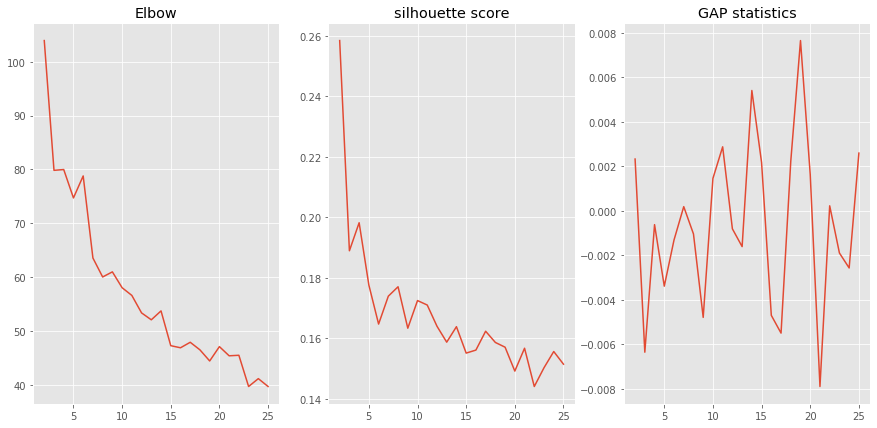

In [167]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_metrics_for_n_clusters(data, kmax, nrefs=3, verbose=True):
    sse = []
    sil = []
    gaps = []
    for k in range(2, kmax + 1):
        if verbose:
            print('Starting for k:', k)
        kmeans = KMeans(n_clusters = k).fit(data)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(data)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(data)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (data[i, 0] - curr_center[0]) ** 2 + (data[i, 1] - curr_center[1]) ** 2

        sil.append(silhouette_score(data, pred_clusters, metric = 'euclidean'))

        sse.append(curr_sse)

        # code adapted from https://anaconda.org/milesgranger/gap-statistic/notebook
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        origDisp = km.inertia_

        # Calculate gap statistic
        gaps.append(np.log(np.mean(refDisps)) - np.log(origDisp))

    return sse, sil, gaps


kmax = 25
wss, silhouette, gap_statistics = calculate_metrics_for_n_clusters(latent_space_train, kmax, verbose=False)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))

ax[0].plot(list(range(2, kmax + 1)), wss)
ax[0].set_title('Elbow')

ax[1].plot(list(range(2, kmax + 1)), silhouette)
ax[1].set_title('silhouette score')

ax[2].plot(list(range(2, kmax + 1)), gap_statistics)
ax[2].set_title('GAP statistics')

plt.show()

In [0]:
def calculate_probabilities_and_samples_per_cluster(clusters, labels, classes):
    cl = []
    for c in clusters:
        ind = np.where(labels == c)[0]

        cl_c = []
        for i in ind:
            cl_c.append(classes[i])

        cl.append(cl_c)

    prediction_matrix = np.zeros((len(cl), len(most_common_disorders)))
    samples = np.zeros(len(cl))
    for i, c in enumerate(cl):
        prediction_matrix[i] = np.sum(c, axis=0) / len(c)
        samples[i] = len(c)
        
    return prediction_matrix, samples

In [170]:
from sklearn.cluster import Birch, KMeans

distance_probs = list()
verbose = False

n_clusters = 14
clustering = KMeans(n_clusters=n_clusters).fit(latent_space_train)

labels_train = clustering.predict(latent_space_train)
labels_test = clustering.predict(latent_space_test)

clusters = np.unique(labels_train)

prediction_matrix_train, samples_train = calculate_probabilities_and_samples_per_cluster(clusters, labels_train, train_classes)
prediction_matrix_test, samples_test = calculate_probabilities_and_samples_per_cluster(clusters, labels_test, test_classes)

if verbose:
    print('================================================================================')
    print(n_clusters)
    print(prediction_matrix_train)
    print(prediction_matrix_test)

distance_probs.append(np.sum((prediction_matrix_train - prediction_matrix_test) ** 2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


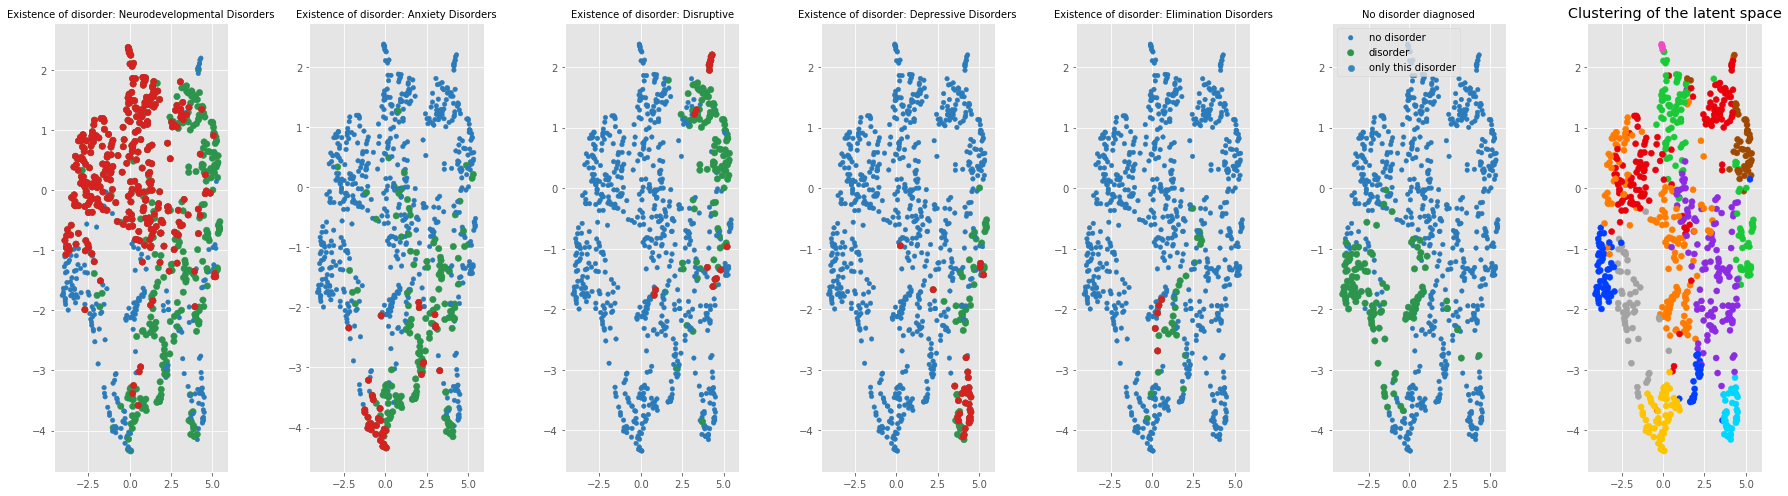

In [171]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_categories_1(embedding, classes, most_common_disorders, n_clusters, cluster_labels, small_size=20, large_size=40):
    fig, ax = plt.subplots(nrows=1, ncols=len(most_common_disorders) + 2, figsize=(25, 7))

    def have_only_disorder(cls, dis):
        res = set(list(range(cls.shape[0])))

        for k in range(cls.shape[1]):
            if k == dis:
                res = res & set(np.where(cls[:, k] == 1)[0])
            else:
                res = res & set(np.where(cls[:, k] == 0)[0])

        return np.array(list(res), dtype=np.int16)

    blue = sns.color_palette("Blues")[-2]
    red = sns.color_palette("Reds")[-2]
    green = sns.color_palette("Greens")[-2]
    for i in range(len(most_common_disorders)):
        ax[i].scatter(embedding[:, 0], embedding[:, 1],
                      c=[green if x == 1 else blue for x in classes[:, i]],
                      s=[large_size if x == 1 else small_size for x in classes[:, i]])
        only_disorder = have_only_disorder(classes, i)
        ax[i].scatter(embedding[only_disorder, 0], embedding[only_disorder, 1],
                      c=[red for _ in range(len(only_disorder))], s=large_size)
        # ax[i].set_gca().set_aspect('equal', 'datalim')
        ax[i].set_title('Existence of disorder: ' + most_common_disorders[i], fontsize=10)

    indx = np.where(np.sum(classes, axis=1) > 0)[0]
    ax[-2].scatter(embedding[indx, 0], embedding[indx, 1], c=[blue for _ in range(len(indx))], label='no disorder',
                   s=small_size)
    indx = np.where(np.sum(classes, axis=1) == 0)[0]
    ax[-2].scatter(embedding[indx, 0], embedding[indx, 1], c=[green for _ in range(len(indx))], label='disorder',
                   s=large_size)
    # dummy to get no indices
    indx = np.where(np.sum(classes, axis=1) == len(most_common_disorders) + 1)[0]
    ax[-2].scatter(embedding[indx, 0], embedding[indx, 1], c=[red for _ in range(len(indx))],
                   label='only this disorder', s=large_size)
    ax[-2].set_title('No disorder diagnosed', fontsize=10)
    ax[-2].legend()

    ax[-1].scatter(embedding[:, 0], embedding[:, 1],
                   c=[sns.color_palette("bright", n_clusters)[i] for i in cluster_labels])
    ax[-1].set_title('Clustering of the latent space')

    plt.tight_layout()
    plt.show()

plot_categories_1(embedding_train, train_classes, most_common_disorders, n_clusters, labels_train)

In [0]:
# plot_categories_1(embedding_test, test_classes, most_common_disorders, n_clusters, labels_test)

In [0]:
# plot_categories_1(embedding_test, predictions_labels_test, most_common_disorders, n_clusters, labels_test)

In [0]:
def print_array(arr):
    for i in arr:
        print("{:.3f} ".format(i), end='')
    print()

i = 0
for a,b in zip(prediction_matrix_train, prediction_matrix_test):
    print('------------------------------', samples_train[i], samples_test[i])
    print_array(a)
    print_array(b)
    i += 1

In [0]:
from sklearn.metrics import f1_score
import warnings

def f1_per_class_n(true, predictions):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1_scores = list()
        for i in range(true.shape[1]):
            f1_scores.append(f1_score(true[:, i], predictions[:, i]))

    return f1_scores

In [0]:
# predictions based on these clusters merely! 
thresholds = np.array([0.4, 0.2, 0.2, 0.85, 0.1])

predictions = np.zeros((len(test), len(most_common_disorders)))
index = 0

for index in range(len(test)):
    predictions[index] = (prediction_matrix_train[labels_test[index]] > thresholds).astype(np.int)

In [0]:
def f1_per_class(true, predictions):
    if not issubclass(predictions.dtype.type, np.integer):
        predictions = before_softmax_to_predictions(predictions)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1_scores = list()
        for i in range(true.shape[1]):
            f1_scores.append(f1_score(true[:, i], predictions[:, i], average='macro'))

    return f1_scores


In [219]:
def f1_per_class_n(true, predictions):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        f1_scores = list()
        for i in range(true.shape[1]):
            f1_scores.append(f1_score(true[:, i], predictions[:, i], average='macro'))

    return f1_scores


print('Normal predictions', f1_per_class_n(test_classes, predictions_labels_test))
print('Predictions based on clusters', f1_per_class_n(test_classes, predictions))

Normal predictions [0.7480296154764747, 0.7508854781582055, 0.7320634920634921, 0.7163978494623656, 0.4815724815724816]
Predictions based on clusters [0.6653844856092047, 0.7027788449225253, 0.6844466600199401, 0.7540038043811743, 0.5233309963387085]


In [0]:
# plt.plot(list(range(2, 17)), np.array(distance_probs) / np.array(list(range(2, 17))))

In [0]:
from scipy.spatial.distance import jensenshannon

In [95]:
jensenshannon(samples_train, samples_test)

0.11409365665204847

In [0]:
# Relation with recommender systems?
# Community detection approaches from network science to cluster the spaces 